In [1]:
import matplotlib.pyplot as plt
from stompy import utils
import xarray as xr

import stompy.model.schism.schism_model as sch
import peschism
import numpy as np
import os
%matplotlib notebook

In [2]:
run_dirs=['data_schmouth_v020']

In [3]:
run_dir=run_dirs[0]
model=peschism.PescaSchism.load(run_dir)

INFO:numexpr.utils:Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:HydroModel:Resampling leads to 295 points for thalweg_pesc
INFO:HydroModel:Resampling leads to 204 points for thalweg_butano


Setting seepage


In [4]:
ms=model.map_output(1)

<IPython.core.display.Javascript object>


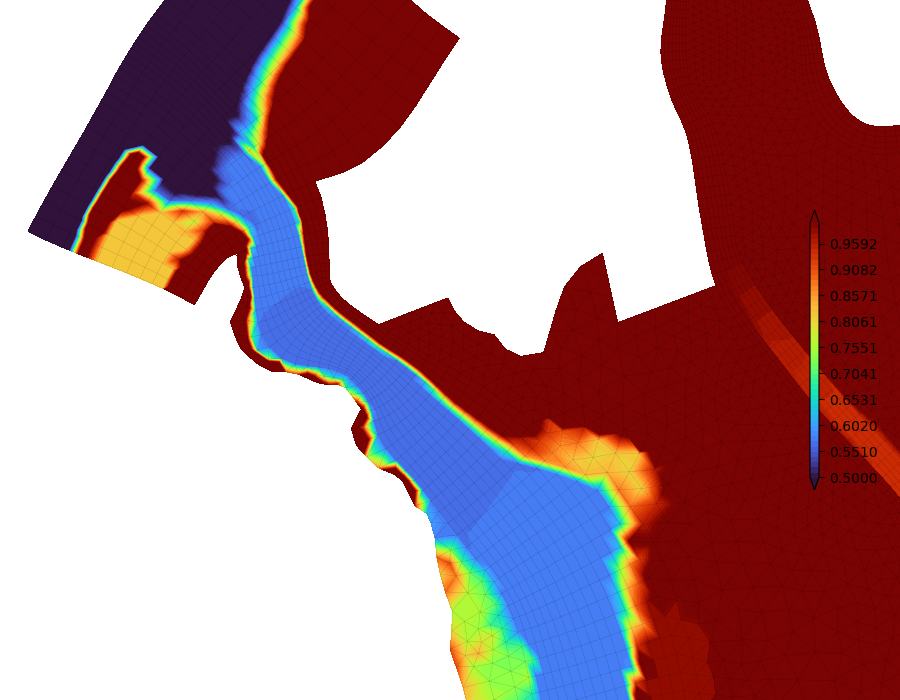

(551946.6884960784, 552446.2403808217, 4124412.8287927504, 4124801.369147551)

In [9]:
fig,ax=plt.subplots(figsize=(9,7))

ms.grid.plot_edges(color='k',lw=0.3,alpha=0.2)
cset=ms.grid.contourf_node_values(ms.elev.isel(time=9).values,
                                  np.linspace(0.5,1.0,50),extend='both',cmap='turbo')
ax.axis('off')
ax.set_position([0,0,1,1])
ax.axis('tight')
ax.axis('equal')
cax=fig.add_axes([0.9,0.3,0.01,0.4])
plt.colorbar(cset,cax=cax)
ax.axis((551946.6884960784, 552446.2403808217, 4124412.8287927504, 4124801.369147551))

In [14]:

speed.max()

1.3840256

<IPython.core.display.Javascript object>


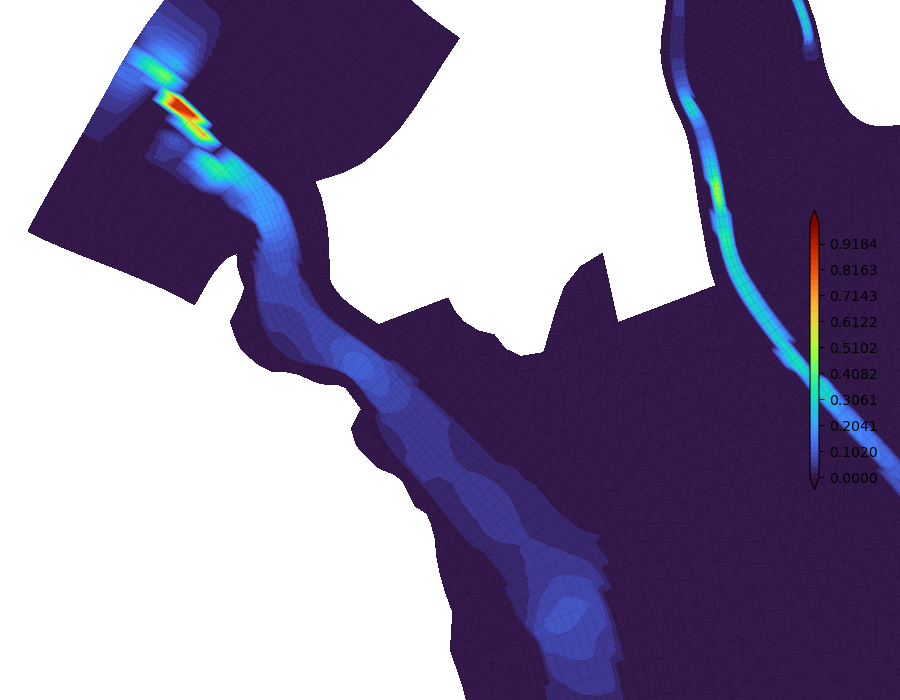

(551946.6884960784, 552446.2403808217, 4124412.8287927504, 4124801.369147551)

In [15]:
fig,ax=plt.subplots(figsize=(9,7))

ms.grid.plot_edges(color='k',lw=0.3,alpha=0.2)
speed=utils.mag(ms.dahv.isel(time=9).values)
cset=ms.grid.contourf_node_values(speed,
                                  np.linspace(0.0,1.0,50),extend='both',cmap='turbo')
ax.axis('off')
ax.set_position([0,0,1,1])
ax.axis('tight')
ax.axis('equal')
cax=fig.add_axes([0.9,0.3,0.01,0.4])
plt.colorbar(cset,cax=cax)
ax.axis((551946.6884960784, 552446.2403808217, 4124412.8287927504, 4124801.369147551))

<IPython.core.display.Javascript object>


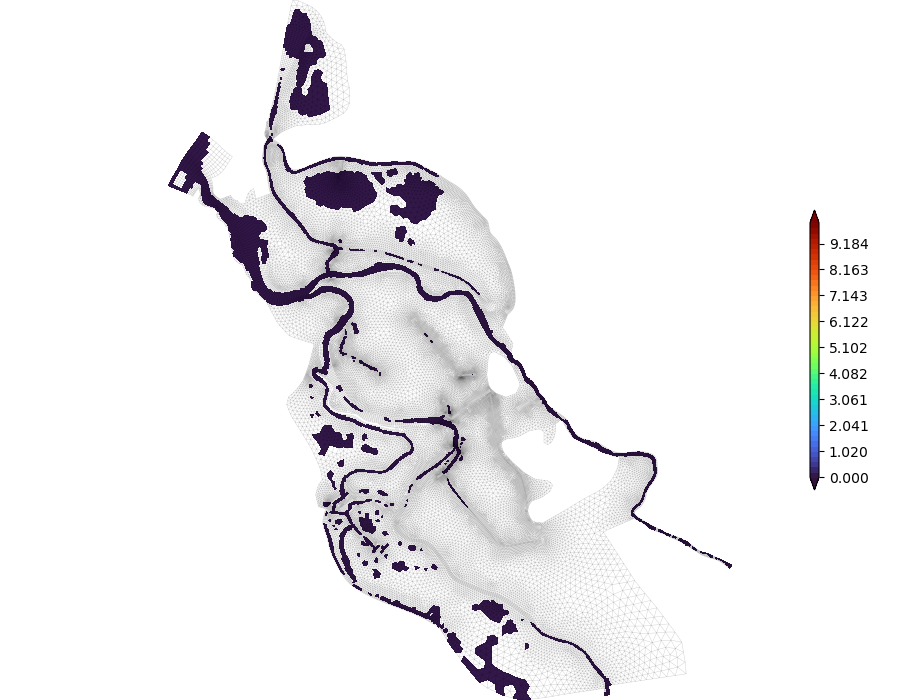

In [10]:
# Surface salinity:
fig,ax=plt.subplots(figsize=(9,7))

ti=-1
ms.grid.plot_edges(color='k',lw=0.3,alpha=0.2)
wet_cell=ms.wetdry_elem.isel(time=ti).values<0.5

#data=ms.salt.isel(time=ti,nSCHISM_vgrid_layers=-1).values

s_top=ms.salt.isel(time=ti,nSCHISM_vgrid_layers=-1).values
s_bed=ms.salt.isel(time=ti,nSCHISM_vgrid_layers=0).values
data=s_bed-s_top

cset=ms.grid.contourf_node_values(data,
                                  np.linspace(0,10,50),
                                  tri_kwargs=dict(cell_mask=wet_cell),
                                  extend='both',cmap='turbo')
ax.axis('off')
ax.set_position([0,0,1,1])
ax.axis('tight')
ax.axis('equal')
cax=fig.add_axes([0.9,0.3,0.01,0.4])
plt.colorbar(cset,cax=cax)

<IPython.core.display.Javascript object>


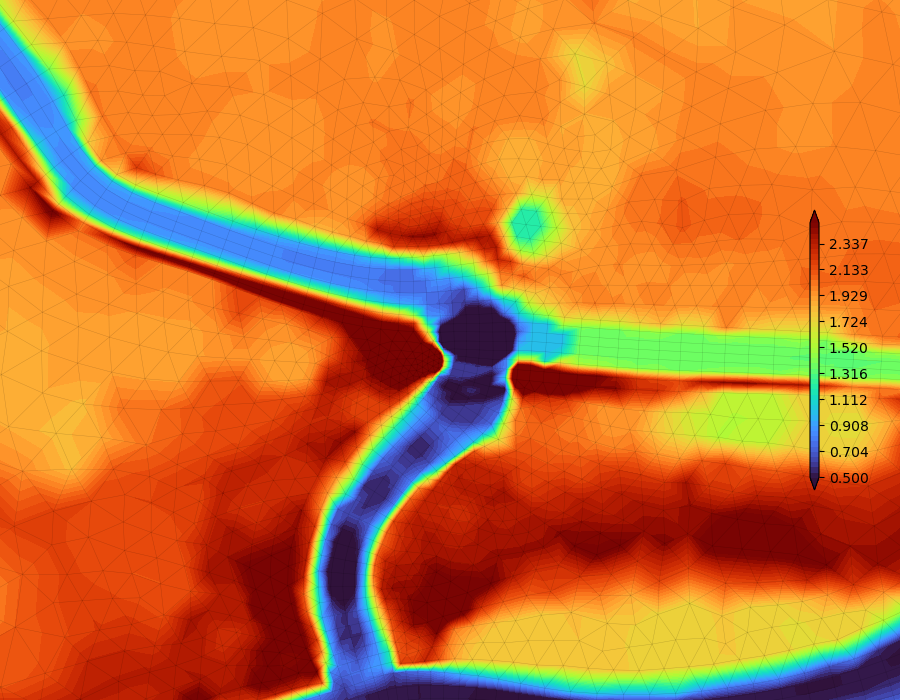

In [15]:
fig,ax=plt.subplots(figsize=(9,7))

ms.grid.plot_edges(color='k',lw=0.3,alpha=0.2)
cset=ms.grid.contourf_node_values(-ms.grid.nodes['depth'],
                                  np.linspace(0.5,2.5,50),extend='both',cmap='turbo')
ax.axis('off')
ax.set_position([0,0,1,1])
ax.axis('tight')
ax.axis('equal')
cax=fig.add_axes([0.9,0.3,0.01,0.4])
plt.colorbar(cset,cax=cax)

In [5]:
ds=model.station_output()

<IPython.core.display.Javascript object>


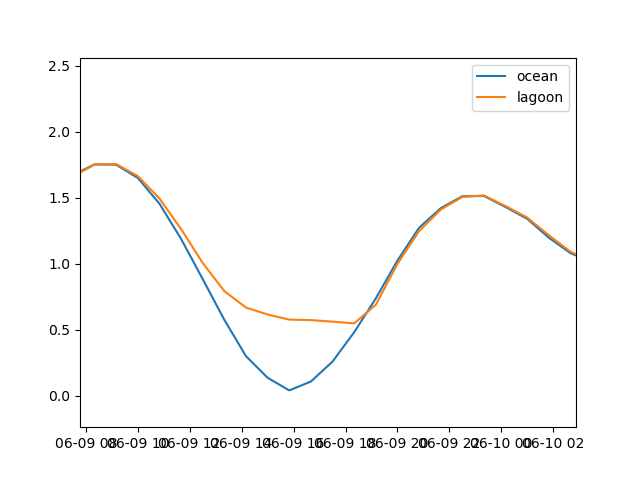

In [6]:
# Find a spot in the lagoon, and a spot near the ocean
xy_ocean=[552041.12, 4124763.48]
xy_lagoon=[552277.89, 4124400.70]

sta_ocean=np.argmin( utils.dist(np.c_[ds.x, ds.y], xy_ocean))
sta_lagoon=np.argmin( utils.dist(np.c_[ds.x, ds.y], xy_lagoon))

plt.figure()
plt.plot(ds.time,ds['elev'].isel(station=sta_ocean),label='ocean')
plt.plot(ds.time,ds['elev'].isel(station=sta_lagoon),label='lagoon')
plt.legend()

In [16]:
ms.dss[0]

<xarray.Dataset>
Dimensions:            (nSCHISM_hgrid_edge: 7400, nSCHISM_hgrid_face: 4416, nSCHISM_hgrid_node: 2980, nSCHISM_vgrid_layers: 2, time: 144, two: 2)
Coordinates:
  * time               (time) datetime64[ns] 2016-06-09T01:40:00 ... 2016-06-19
Dimensions without coordinates: nSCHISM_hgrid_edge, nSCHISM_hgrid_face, nSCHISM_hgrid_node, nSCHISM_vgrid_layers, two
Data variables:
    wetdry_node        (time, nSCHISM_hgrid_node) float32 ...
    wetdry_elem        (time, nSCHISM_hgrid_face) float32 ...
    wetdry_side        (time, nSCHISM_hgrid_edge) float32 ...
    zcor               (time, nSCHISM_hgrid_node, nSCHISM_vgrid_layers) float32 ...
    elev               (time, nSCHISM_hgrid_node) float32 ...
    dahv               (time, nSCHISM_hgrid_node, two) float32 ...
    temp               (time, nSCHISM_hgrid_node, nSCHISM_vgrid_layers) float32 ...
    salt               (time, nSCHISM_hgrid_node, nSCHISM_vgrid_layers) float32 ...
    hvel               (time, nSCHISM_hgrid_node, nSCHISM_vgrid_layers, two) float32 ...
    SED_depth_change   (time, nSCHISM_hgrid_node) float32 ...
    SED_bed_stress     (time, nSCHISM_hgrid_node) float32 ...
    SED_bed_roughness  (time, nSCHISM_hgrid_node) float32 ...
    SED_TSC            (time, nSCHISM_hgrid_node, nSCHISM_vgrid_layers) float32 ...
    bed_thickness      (time, nSCHISM_hgrid_face) float32 ...
    time_s             (time) float32 6e+03 1.2e+04 ... 8.58e+05 8.64e+05

In [ ]:
ms['SED_depth_change'].isel(time=9).values.max()